In [1]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

# Homework 5

In this homework, we will learn about the basics of gene expression data analysis. Clever biologists have found a way to measure how much each gene is *expressed* in each cell in an experiment. The way we do this is by counting the number of mRNA molecules in each cell. Remember, DNA holds the instructions to how to build proteins, but DNA can't be turned into proteins directly. Instead, DNA is transcribed into mRNA, which is then translated into proteins by ribosomes. If we measure the amount of mRNA in a cell, we can tell what proteins the cell is making, and indirectly, what the cell is doing as a whole.

## Problem 1: Constructing the count matrix

Each single-cell gene-expression experiment takes a tissue sample, containing lots and lots of cells. For each of these cells, we want to measure the amount of mRNA coming from a particular gene, and create a *gene-expression matrix*, where the rows will correspond to individual cells, and the columns will correspond to individual genes. So, our output will be an $N$ by $G$ matrix where $N$ is the number of cells and $G$ is the number of genes.

Before this tissue, i.e. collection of cells, can be put into a sequencer, it has to undergo some special treatment. For instance, if we were to just take all the cells, and gather all their mRNA material, and put this into a sequencer, we wouldn't be able to tell which cell each mRNA molecule came from. So, we have to attach a *cell barcode* to each cell. This barcode will then be attached to all the mRNA reads coming from this cell. We will use this barcode to determine which cell each read came from. The sequencer also needs to know which molcules to sequence, we only want it to sequence mRNA molecules, and nothing else. To do this, we can use special molecular primer which bind to the poly-A tail of mRNA molecules. Don't worry if you don't understand this, this isn't important to us. The important thing is that each mRNA molecule, and therefore each read, comes with three pieces. First is the cell barcode, then is the molecular primer, then is the actual mRNA fragment.

Each read is comprised of three parts. The first 12 bases is the cell barcode. The next 24 bases is the oligo-dT primer, which we will discard, since it carries no information. The remaining bases are the actual mRNA fragment of the gene of interest. A more realistic schematic can be found [here](https://training.galaxyproject.org/training-material/topics/transcriptomics/images/celseq2_schema.svg). If you want to find out more about this, [this tutorial](https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/scrna-umis/tutorial.html) seems informative.

**[TASK]**

We have prepared for you a collection of reads in (`data/reads.fastq`). The reads come in form of a FASTQ file, containing Phred quality scores for each nucleotide (this comes out of the sequencer). We will ignore these scores in this homework. You can easily read these files using Biopython. Your job is to take each read, and determine which gene and cell it corresponds to. The reads come from SARS-CoV-2 infected tissue, so we'll be interested in which SARS-CoV-2 genes are expressed. This time, we won't be using NCBI for SARS-CoV-2 gene annotations, but we will use a more standard approach. Two files are important: `data/sars-cov-2.fa` is a fasta file containing the reference SARS-CoV-2 genome, and `genes.gff` contains the gene annotations in GFF format. You are required to use these files in this homework, as we have removed some genes to make the exercise easier.

For each read in `reads.fasq`, you must extract the cell barcode and mRNA fragment (and drop the primer). Because sequencers aren't perfect and introduce errors, we'll have to run local alignment to determine where on the SARS-CoV-2 genome each mRNA fragment aligns to. For alignment, you can either adapt your implementation from HW2, or you can use the [`pairwise2`](https://biopython.org/docs/1.76/api/Bio.pairwise2.html) module from Biopython.

Once you have your alignment, determine which gene region this mRNA fragment belongs to. For instance, if we have gene XYZ ranging from positions 250 to 1250 on the reference genome, a fragment that maps into this region e.g. 450-600 can be considered as an expression of this gene. Since we constructing a count matrix, we really are just counting the fragments. So, for instance, if the barcode is AAACCCTTT and we've mapped the read to gene XZY, we'd increase the cell in our count matrix at row AAACCCTTT and column XZY by +1.

One more important thing we must account for is possible contamination. If the tissue sample is contaminated with cells from other organisms, we might get reads that do not map well to our reference genome. To circumvent this, we will apply a simple threshold to our aligned reads. We will calculate the Hamming similarity of the alignments, and only keep the reads that map to our reference genome with a similarity of 0.95 or higher.

Your task is to implement four functions `split_read`, `map_read_to_gene`, `generate_count_matrix`, `filter_matrix` in `helper_functions.py`. Each function is worth an equal number of points. Please go through the docstrings for implementation details. Once you've implemented these functions, create a count matrix from the reads provided in `data/reads.fastq`.

**[30 points]**


*Notes:*

For the purposes of keeping things simple, we won't deal with RNA sequences, but with DNA sequences here. We also won't have to find the reverse complement of the mRNA fragment, you can just take each sequence as is, and align it to the reference genome. Finally, we will assume that the cell barcodes contain no sequencing errors; sequencing errors are limited to the mRNA portion of each read.

In [2]:
!python test_helper_functions.py

.....
----------------------------------------------------------------------
Ran 5 tests in 0.050s

OK


## Problem 2: A realistic example

In the previous problem, we learned about how to create count matrices, and what the numbers inside them mean. However, this scenario is unrealistically small. In the real world, single-cell RNA-sequencing runs produce millions of reads, which must all be mapped into the genome. There are also intronic regions to consider, which can further complicate our lives. Fortunately, we don't have to worry about implementing these algorithms ourselves. There are well established pipelines that go through this entire process for us. For instance, RNA sequence alignment is usually done using the STAR aligner, or bowtie2 (in case you ever run accross these in the wild).

It doesn't really make much sense to align reads to the SARS-CoV-2 genome. After all, the goal of the virus is to replicate, and that's its only job. Even if we sequence infected cells and look at reads aligning to the SARS-CoV-2 genome, we won't really get much diversity, because -- most likely -- we'll see that all the genes are being expressed all the time. It would be much more interesting to instead see the effects of SARS-CoV-2 on a host organism, e.g. a human. Human cells are much more diverse, as they have to perform a wide range of tasks. The way they achieve this is by activating different sets of genes, all of which we can measure using single-cell RNA sequencing. Then, if we know which cells come from a healthy person and which cells come from an infected person, we can compare how SARS-CoV-2 impacts the gene programs that usually go on inside the cell.

In this problem, we'll look at a real-world count matrix containing exactly this kind of data. These count matrices are most often readily available on public repositories e.g. NCBI GEO, and others. Here, we've already provided you with a count matrix -- `data/homework5.h5ad`. The data set contains cells from several healthy and several SARS-CoV-2-infected patients. The data contains cells from the peripheral immune system. Inspecting this, we might begin to unravel how the immune system responds to infection. The H5AD format is built on top of HDF5 and is fairly standard withing the gene-expression analysis ecosystem. You can easily load this data using `scanpy`. `scanpy` is the standard single-cell data analysis toolkit in Python. Refer to the scanpy documentation for more information and see in particular `sc.read_h5ad`.

A full blown analysis of this data is, unfortunately, out of scope for this subject. However, we can still look at some basic statistics that will give us a better idea of what kind of problems we may deal with when working with single-cell RNA-seq data. We'll limit our analysis to some basic statistica.
Report the number of cells and the number of genes in the `num_cells` and `num_genes` variables.
For every gene, calculate the number of cells that this gene is expressed in (>0). Then, for every cell, calculate the number of genes that are expressed in every cell. Plot the distribution over all cells and genes, and save your plots into `realistic_gene_dist.png` and `realistic_cell_dist.png`, respectively.

Looking at these distributions, it seems that some cells have only a handful of genes that are expressed. And looking at the genes, there seem to be a good number of genes that are expressed in only a few cells (if at all!). Does it make sense to perform any analysis on these cells/genes? How reliable will these results be? Most likely, we'd need to apply some kind of filtering before proceeding with further analyses. How would you go about filtering this data? Save your answers into the `filtering_comments` variable.

The data was obtained from 
> Wilk, A.J., Rustagi, A., Zhao, N.Q. et al. A single-cell atlas of the peripheral immune response in patients with severe COVID-19. Nat Med 26, 1070–1076 (2020). 

In [3]:
from helper_functions import *
import scanpy as sc

count_matrix = sc.read_h5ad('data/homework5.h5ad').to_df()
count_matrix.shape

(8000, 26361)

In [4]:
filtered = filter_matrix(count_matrix, 1, 1)
data = filtered.values

genes = []
cells = []
for i in range(len(data)):
    cells.append(len(data[i, data[i, :] > 0]))

for i in range(len(data[0])):
    genes.append(len(data[data[:, i] > 0, i]))  

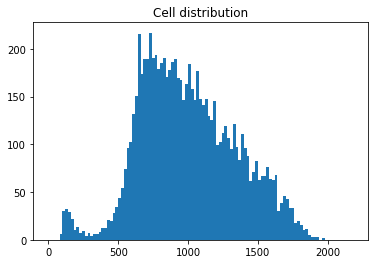

In [5]:
import matplotlib.pyplot as plt

hist_kwargs = dict(bins=list(range(0, 2200, 20)), lw=1.2)
p = plt.hist(cells, **hist_kwargs)
p = plt.title('Cell distribution')
p = plt.savefig('realistic_cell_dist.png')

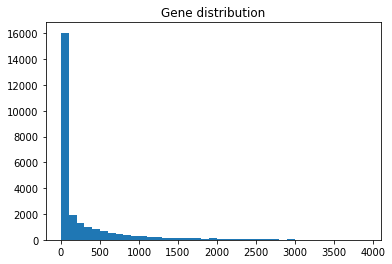

In [6]:
hist_kwargs = dict(bins=list(range(0, 4000, 100)), lw=1.2)
p = plt.hist(genes, **hist_kwargs)
p = plt.title('Gene distribution')
p = plt.savefig('realistic_gene_dist.png')

In [7]:
num_cells = 8000
num_genes = 26361

## Bonus problem: Investigating unmapped reads

When mapping the reads, we saw that some of the reads don't map well to the SARS-CoV-2 genome; their similarity was underneath our predetermined threshold 0.95, so they weren't counted in our count matrix. Investigate these reads. A low similarity indicates that they don't correspond to DNA from the SARS-CoV-2 genome. So where do they come from? How might this DNA have ended up here in this sample? Save your answers into the `unmapped_reads_comments` variable.

**[5 pts]**

*Hint:* Remember what we did in HW1.

In [8]:
unmapped_reads_comments = """
"""

## Bonus problem: Single-cell data analysis

We now know what a count matrix is and how to create one. However, the real fun begins when we actually start working with this matrix and apply statistical methods to maybe uncover some interesting facts about the tissue. This is called single-cell RNA-seq data analysis. Up until now -- in the previous homeworks -- the methods we learned about in this course have been very bioinformatics-specific. We learned about DNA, alignment algorithms, graph assembly algorithms, and so on. But now we have a matrix, and we can reach into other fields of statistical analyses for a wide range of tools. One of the most powerful toolboxes for finding structure in these kinds of matrices is machine learning.

Single-cell data analysis usually involves a number of predefined steps, that involve using a mix of bioinformatics-specific proceedures as well as more general machine learning techniques, e.g. dimensionality reduction and clustering. Of course, we won't go into machine learning here -- there are entire courses dedicated to machine learning -- but we'll follow a simple tutorial to get our feet wet and get a feeling for what can be done with the count matrices we've created here.

In this exercise, we'll be continuing our exploration of the SARS-CoV-2 count matrix we started working with in Problem 2 (`data/homework5.h5ad`) and run a standard analysis pipeline.
We'll be using scanpy. Scanpy is a Python library for single-cell data analysis that provides a nice and easy interface for working with single-cell data. Scanpy also comes complete with several helpful tutorials that are very useful when getting started. Follow this beginner clustering tutorial found at https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html, and submit the required images.

You're required to submit three images, each worth 5 points:
1. PCA (`sc_analysis_pca.png`)
2. UMAP or t-SNE colored by clusters (`sc_analysis_clusters.png`)
3. UMAP or t-SNE colored by some kind of differential expression (`sc_analysis_deg.png`)

You can get additional points if you perform additional analyses, and write your findings into the `sc_analysis_extra_comments` variable.

**[15 points]**

In [9]:
sc_analysis_extra_comments = """
"""

In [10]:
from Bio import Entrez, SeqIO
from Bio.SeqRecord import SeqRecord

def load_records(filename, filetype):
    virus_records = []
    for record in SeqIO.parse(filename, filetype):
        virus_records.append(str(record.seq))
    return virus_records

In [11]:
reads = load_records('data/reads.fastq', 'fastq')
sars = load_records('data/sars-cov-2.fa', 'fasta')[0]
genes = read_gff('data/genes.gff')
#matrix = generate_count_matrix(reads, sars, genes, 0.95)